In [30]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import graspologic as gl
from pathlib import Path

In [31]:
# get the current working directory
path = Path.cwd()
path_syncounts = path / "data" / "41586_2021_3778_MOESM4_ESM.xlsx"

In [32]:
# read in the data
df = pd.read_excel(path_syncounts, sheet_name="Dataset8", header=2)
# remove first row
df = df.iloc[1:]
# remove the first column
df = df.iloc[:,1:]

#name the first column "neuron type"
df.columns = ["neuron type"] + list(df.columns[1:])
# name the second column "neuron name"
df = df.rename(columns={df.columns[1]: "neuron name"})

# if neuron type is nan, copy the previous neuron type
df["neuron type"] = df["neuron type"].fillna(method='ffill')

# assert that all neuron names are unique
row_names = df["neuron name"]
col_names = df.columns[2:]

assert row_names.nunique() == len(row_names)
assert col_names.nunique() == len(col_names)


# for neuron type, map Sensory to Sens.
df["neuron type"] = df["neuron type"].str.replace("Sensory", "Sens.")
df["neuron type"] = df["neuron type"].str.replace("Motor", "Mot.")
df["neuron type"] = df["neuron type"].str.replace("Inter", "Inter.")
df["neuron type"] = df["neuron type"].str.replace("Modulatory", "Mod.")
df["neuron type"] = df["neuron type"].str.replace("Motor", "Mot.")

G = nx.DiGraph()

# add edges
for i, row in df.iterrows():
    # iterate through the entries of row
    post = row["neuron name"]
    for pre, val in row.items():
        if pre not in ["neuron type", "neuron name"] and val > 0:
            G.add_edge(pre, post, weight=val)
    


# add neuron types
for i, row in df.iterrows():
    neuron_name = row["neuron name"]
    neuron_type = row["neuron type"]
    # if neuron name is not in the graph, add it
    if neuron_name not in G.nodes:
        G.add_node(neuron_name)
    G.nodes[neuron_name]["neuron type"] = neuron_type
    

/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_22349/3360854453.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["neuron type"] = df["neuron type"].fillna(method='ffill')


In [33]:
transmitters = {'ADFL':'ACh',
 'ADFR':'ACh',
 'ADLL':'glut',
 'ADLR':'glut',
 'AFDL':'glut',
 'AFDR':'glut',
 'ALML':'glut',
 'ALMR':'glut',
 'ALNL':'ACh',
 'ALNR':'ACh',
 'AQR':'glut',
 'ASEL':'glut',
 'ASER':'glut',
 'ASGL':'glut',
 'ASGR':'glut',
 'ASHL':'glut',
 'ASHR':'glut',
 'ASIL':'DAF-28',
 'ASIR':'DAF-28',
 'ASJL':'NLP-3',
 'ASJR':'NLP-3',
 'ASKL':'glut',
 'ASKR':'glut',
 'AUAL':'glut',
 'AUAR':'glut',
 'AVM':'glut',
 'AWAL':'na',
 'AWAR': 'na',
 'AWBL':'ACh',
 'AWBR':'ACh',
 'AWCL':'glut',
 'AWCR':'glut',
 'BAGL':'glut',
 'BAGR':'glut',
 'DVA':'ACh',
 'FLPL':'glut',
 'FLPR':'glut',
 'IL2DL':'ACh',
 'IL2DR':'ACh',
 'IL2L':'ACh',
 'IL2R':'ACh',
 'IL2VL':'ACh',
 'IL2VR':'ACh',
 'OLLL': 'glutamate',
 'OLLR': 'glutamate',
 'OLQDL': 'glutamate',
 'OLQDR': 'glutamate',
 'OLQVL': 'glutamate',
 'OLQVR': 'glutamate',
 'PLNL': 'ACh',
 'PLNR': 'ACh',
 'SAADL': 'ACh',
 'SAADR': 'ACh',
 'SAAVL': 'ACh',
 'SAAVR': 'ACh',
 'SDQL': 'ACh',
 'SDQR': 'ACh',
 'URBL': 'ACh',
 'URBR': 'ACh',
 'URXL': 'ACh',
 'URXR': 'ACh',
 'URYDL': 'glutamate',
 'URYDR':'glutamate',
 'URYVL': 'glutamate',
 'URYVR': 'glutamate',}


In [34]:
sensories = []

for n in G.nodes:
    if G.nodes[n]["neuron type"] == "Sens.":
        G.nodes[n]["transmitter"] = transmitters[n]


In [35]:
# remove all nodes unless the neuron type is Sens. or Inter.
nodes_to_remove = []
for n in G.nodes:
    if G.nodes[n]["neuron type"] not in ["Sens.", "Inter."]:
        nodes_to_remove.append(n)
G.remove_nodes_from(nodes_to_remove)

transmitter = "ACh"

# remove all edges that are not from Sens. to Inter.
edges_to_remove = []
for e in G.edges:
    if "transmitter" in G.nodes[e[0]] and G.nodes[e[0]]["transmitter"] != transmitter:
        edges_to_remove.append(e)
    elif G.nodes[e[0]]["neuron type"] != "Sens." or G.nodes[e[1]]["neuron type"] != "Inter.":
        edges_to_remove.append(e)
G.remove_edges_from(edges_to_remove)

In [36]:
# remove all nodes that have neuron type equal to Muscle\
muscle_nodes = [n for n in G.nodes if G.nodes[n]["neuron type"] == "Muscle"]
G.remove_nodes_from(muscle_nodes)

A = nx.adjacency_matrix(G).todense()
neuron_types = [G.nodes[n]["neuron type"] for n in G.nodes]

<Axes: title={'center': 'Binarized ACh Sens->Inter Connectome of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)'}>

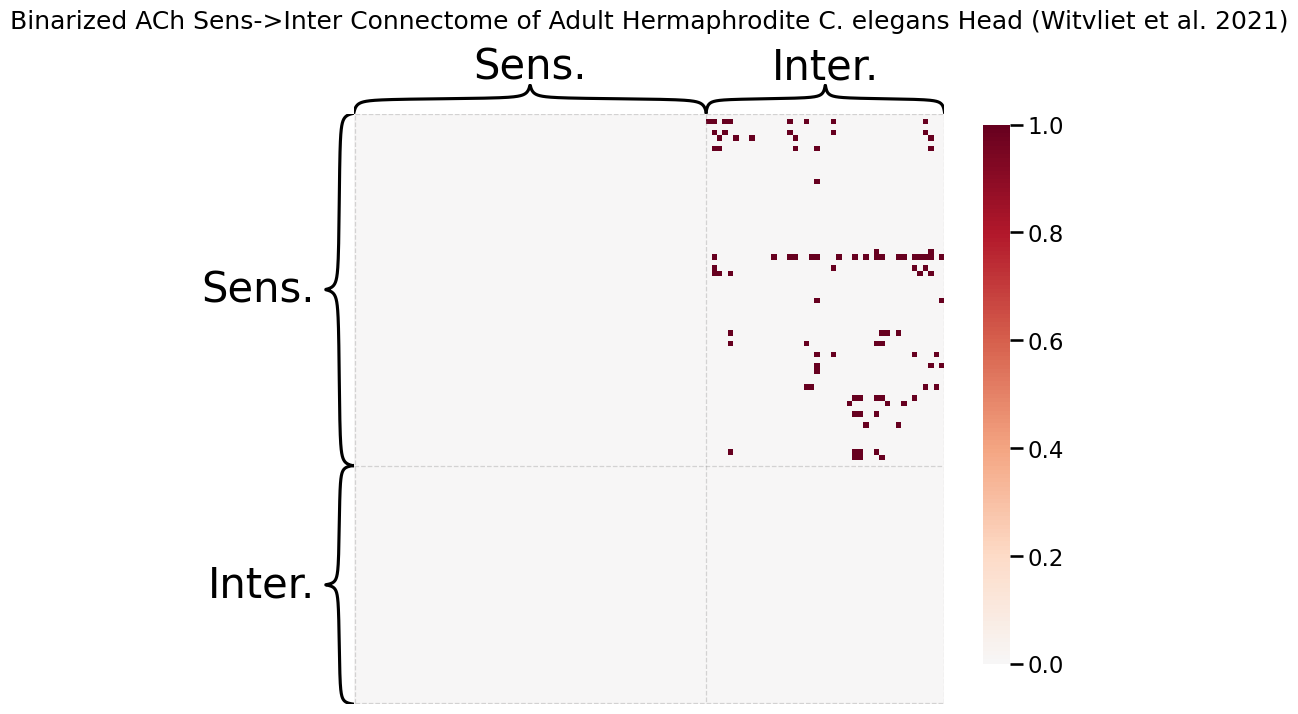

In [37]:
# use gl.plot.heatmap to plot the adjacency matrix and make the figure size 20x20
#fig, ax = plt.subplots(figsize=(20, 20))


title = "Binarized ACh Sens->Inter Connectome of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)"

gl.plot.heatmap(A>0, inner_hier_labels=neuron_types, sort_nodes=False, title=title)#, ax=ax)

